In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from sklearn.covariance import empirical_covariance
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Load data and preprocess
- Load all four species with their high abundance gene set and subsample to only rRNA genes
- Filter out cells containing no information
- Converting genes to protein clusters (PCs) as index
- Assemble for each species pd.df such that all have same dimesions as input for gglasso

In [2]:
ec_mudata = md.read("../data/preprocessed/ec_mudata_preprocessed.h5mu")
ec_adata = ec_mudata["high_abundance_genes"].copy()
ec_adata = ec_adata[:, ec_adata.var["rRNA"]].copy()
sc.pp.filter_cells(ec_adata, min_counts=1)
del(ec_mudata)
print(gc.collect())
ec_adata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


2251


AnnData object with n_obs × n_vars = 2466 × 47
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [3]:
efm_mudata = md.read("../data/preprocessed/efm_mudata_preprocessed.h5mu")
efm_adata = efm_mudata["high_abundance_genes"].copy()
efm_adata = efm_adata[:, efm_adata.var["rRNA"]].copy()
sc.pp.filter_cells(efm_adata, min_counts=1)
del(efm_mudata)
print(gc.collect())
efm_adata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


2245


AnnData object with n_obs × n_vars = 4563 × 52
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [4]:
psa_mudata = md.read("../data/preprocessed/psa_mudata_preprocessed.h5mu")
psa_adata = psa_mudata["high_abundance_genes"].copy()
psa_adata = psa_adata[:, psa_adata.var["rRNA"]].copy()
sc.pp.filter_cells(psa_adata, min_counts=1)
del(psa_mudata)
print(gc.collect())
psa_adata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


2179


AnnData object with n_obs × n_vars = 195 × 30
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [5]:
kp_mudata = md.read("../data/preprocessed/kp_mudata_preprocessed.h5mu")
kp_adata = kp_mudata["high_abundance_genes"].copy()
kp_adata = kp_adata[:, kp_adata.var["rRNA"]].copy()
sc.pp.filter_cells(kp_adata, min_counts=1)
del(kp_mudata)
print(gc.collect())
kp_adata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


2245


AnnData object with n_obs × n_vars = 770 × 44
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells', 'protein_name', 'rRNA', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [6]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2_final_4_species.h5mu'
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 36469 × 33412
  3 modalities
    SC_genes:	36469 x 14009
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	36469 x 13687
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	36469 x 5716
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

Taking the lev6 (most aggregated and connected) protein clusters and translate genes of each strain into cluster \
Note, in adata its obs x var; now we transpose for gglasso

In [7]:
data_nSBM["SC_proteins"].varm["protein_hierarchy"]

,lev0,lev1,lev2,lev3,lev4,lev5,lev6,lev_root
NP_052605.1,lev00totlen16795,forDFlev16795,forDFlev26795,forDFlev36795,forDFlev46795,forDFlev56795,forDFlev66795,root
NP_052606.1,lev00totlen17549,forDFlev17549,forDFlev27549,forDFlev37549,forDFlev47549,forDFlev57549,forDFlev67549,root
NP_052608.1,lev00totlen15594,forDFlev15594,forDFlev25594,forDFlev35594,forDFlev45594,forDFlev55594,forDFlev65594,root
NP_052609.1,lev00totlen12063,forDFlev12063,forDFlev22063,forDFlev32063,forDFlev42063,forDFlev52063,forDFlev62063,root
NP_052610.1,lev00totlen1576,forDFlev1576,forDFlev2576,forDFlev3576,forDFlev4576,forDFlev5576,forDFlev6576,root
...,...,...,...,...,...,...,...,...
WP_004152553.1,lev00totlen14198,forDFlev14198,forDFlev24198,forDFlev34198,forDFlev44198,forDFlev54198,forDFlev64198,root
WP_004178188.1,lev00totlen11303,forDFlev11303,forDFlev21303,forDFlev31303,forDFlev41303,forDFlev51303,forDFlev61303,root
WP_228131004.1,lev00totlen11253,forDFlev11253,forDFlev21253,forDFlev31253,forDFlev41253,forDFlev51253,forDFlev61253,root
WP_228131000.1,lev020totlen21057,forDFlev11057,forDFlev21057,forDFlev31057,forDFlev41057,forDFlev51057,forDFlev61057,root


In [8]:
all_rrna_genes = set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[ec_adata.var["protein"]]["lev6"].values)
all_rrna_genes.update(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[efm_adata.var["protein"]]["lev6"].values)
all_rrna_genes.update(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[psa_adata.var["protein"]]["lev6"].values)
all_rrna_genes.update(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[kp_adata.var["protein"]]["lev6"].values)
len(all_rrna_genes)

58

## EC

In [9]:
ec_obs = pd.DataFrame(index=data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[ec_adata.var["protein"]]["lev6"],
                      data=ec_adata.layers["sqrt_counts"].T.A) 
ec_obs.shape

(47, 2466)

In [10]:
ec_obs.head()

,0,1,2,3,4,5,6,7,8,9,...,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465
lev6,,,,,,,,,,,,,,,,,,,,,
forDFlev6944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
forDFlev62548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forDFlev61171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forDFlev61251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forDFlev62166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Picking 150 random cells from EC because PSA only has 195 cells in dataset and all n_obs have to be of same size in group-GLASSO

In [11]:
ec_obs_sample = ec_obs.sample(n=150, axis=1)
ec_obs_sample.shape

(47, 150)

Calculating the latent correlations with latentcor

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


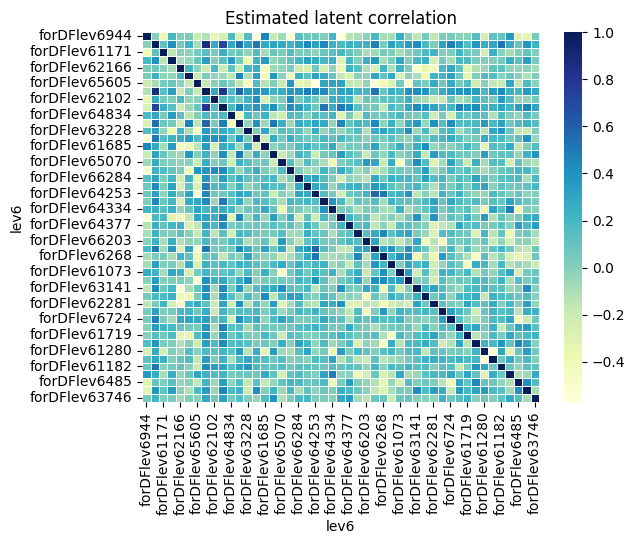

In [12]:
tps = ["tru"] * ec_obs.shape[0]
ec_latent = latentcor(ec_obs.T, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

Adding the remaining genes to the latent correlation matrix so all of them are of the same size

In [13]:
ec_fill_idx = list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[ec_adata.var["protein"]]["lev6"].values))
ec_fill = pd.DataFrame(index=ec_fill_idx, columns=ec_fill_idx)
ec_fill.shape

(11, 11)

<Axes: >

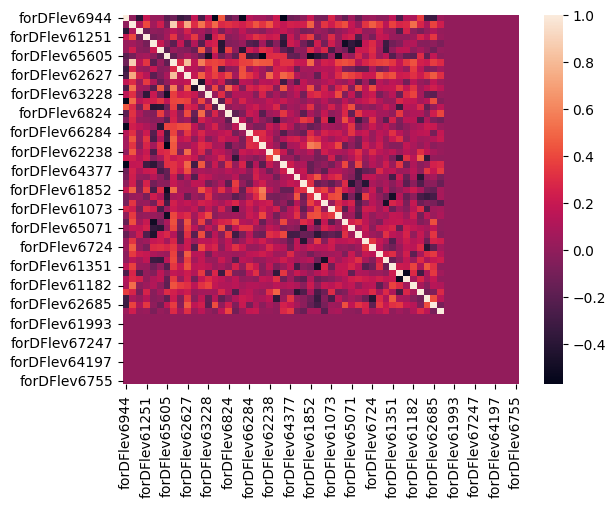

In [14]:
ec_latent_final = pd.concat([ec_latent["R"], ec_fill], axis=0)
ec_latent_final.fillna(0, inplace=True)
sns.heatmap(ec_latent_final)

Same thing for the observations

In [15]:
ec_fill = pd.DataFrame(0, index=list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[ec_adata.var["protein"]]["lev6"].values)),
             columns=ec_obs_sample.columns)
ec_fill.shape

(11, 150)

In [16]:
ec_obs_sample_final = pd.concat([ec_obs_sample, ec_fill])
ec_obs_sample_final.shape

(58, 150)

### EFM

In [17]:
efm_obs = pd.DataFrame(index=data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[efm_adata.var["protein"]]["lev6"],
                      data=efm_adata.layers["sqrt_counts"].T.A) 
efm_obs.shape

(52, 4563)

In [18]:
efm_obs_sample = efm_obs.sample(n=150, axis=1)
efm_obs_sample.shape

(52, 150)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


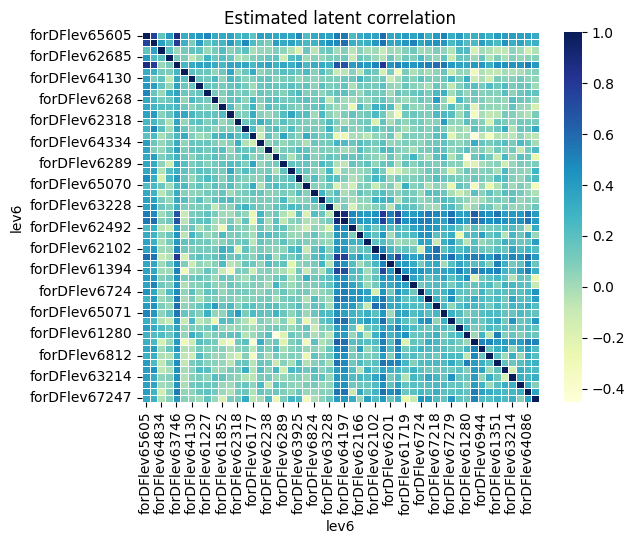

In [19]:
tps = ["tru"] * efm_obs.shape[0]
efm_latent = latentcor(efm_obs.T, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [20]:
efm_fill_idx = list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[efm_adata.var["protein"]]["lev6"].values))
efm_fill = pd.DataFrame(index=efm_fill_idx, columns=efm_fill_idx)
efm_fill.shape

(6, 6)

<Axes: >

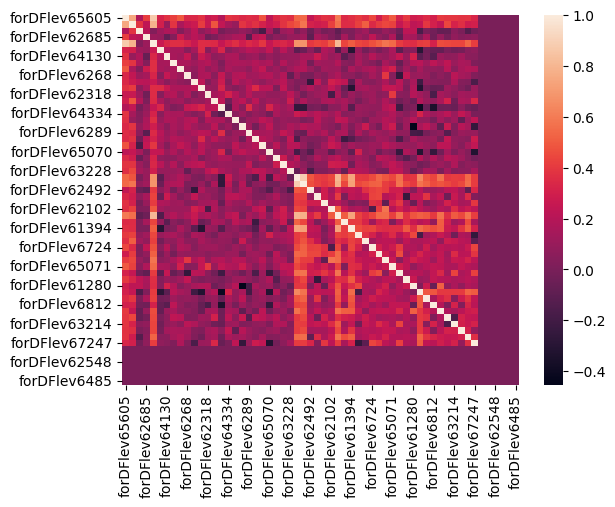

In [21]:
efm_latent_final = pd.concat([efm_latent["R"], efm_fill], axis=0)
efm_latent_final.fillna(0, inplace=True)
sns.heatmap(efm_latent_final)

In [22]:
efm_fill = pd.DataFrame(0, index=list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[efm_adata.var["protein"]]["lev6"].values)),
             columns=efm_obs_sample.columns)
efm_fill.shape

(6, 150)

In [23]:
efm_obs_sample_final = pd.concat([efm_obs_sample, efm_fill])
efm_obs_sample_final.shape

(58, 150)

### PSA

In [24]:
psa_obs = pd.DataFrame(index=data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[psa_adata.var["protein"]]["lev6"],
                      data=psa_adata.layers["sqrt_counts"].T.A) 
psa_obs.shape

(30, 195)

In [25]:
psa_obs_sample = psa_obs.sample(n=150, axis=1)
psa_obs_sample.shape

(30, 150)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


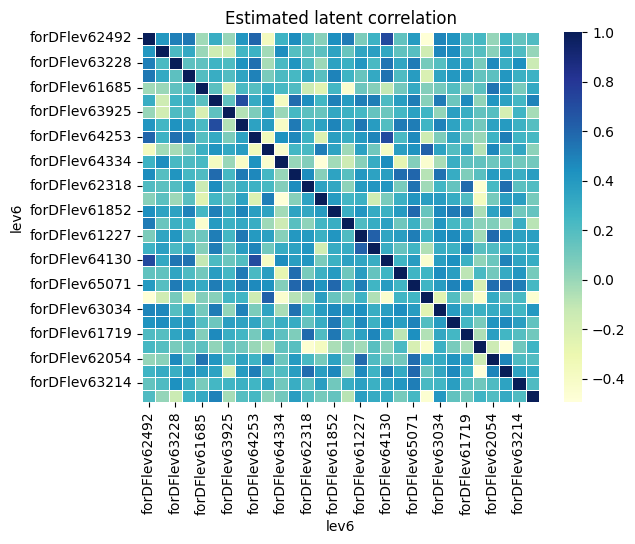

In [26]:
tps = ["tru"] * psa_obs.shape[0]
psa_latent = latentcor(psa_obs.T, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [27]:
psa_fill_idx = list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[psa_adata.var["protein"]]["lev6"].values))
psa_fill = pd.DataFrame(index=psa_fill_idx, columns=psa_fill_idx)
psa_fill.shape

(28, 28)

<Axes: >

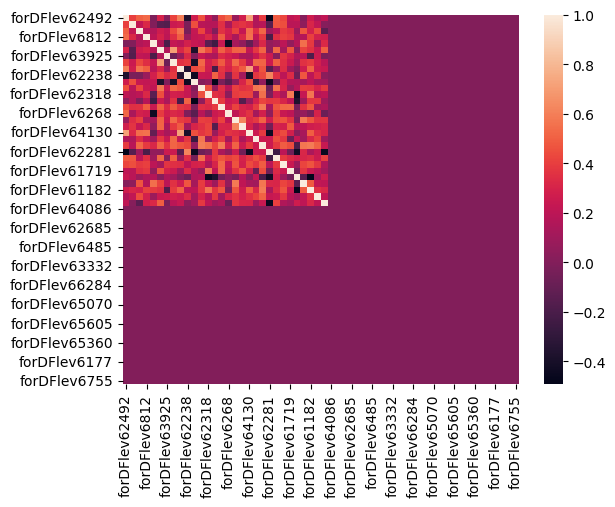

In [28]:
psa_latent_final = pd.concat([psa_latent["R"], psa_fill], axis=0)
psa_latent_final.fillna(0, inplace=True)
sns.heatmap(psa_latent_final)

In [29]:
psa_fill = pd.DataFrame(0, index=list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[psa_adata.var["protein"]]["lev6"].values)),
             columns=psa_obs_sample.columns)
psa_fill.shape

(28, 150)

In [30]:
psa_obs_sample_final = pd.concat([psa_obs_sample, psa_fill])
psa_obs_sample_final.shape

(58, 150)

### KP

In [31]:
kp_obs = pd.DataFrame(index=data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[kp_adata.var["protein"]]["lev6"],
                      data=kp_adata.layers["sqrt_counts"].T.A) 
kp_obs.shape

(44, 770)

In [32]:
kp_obs_sample = kp_obs.sample(n=150, axis=1)
kp_obs_sample.shape

(44, 150)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


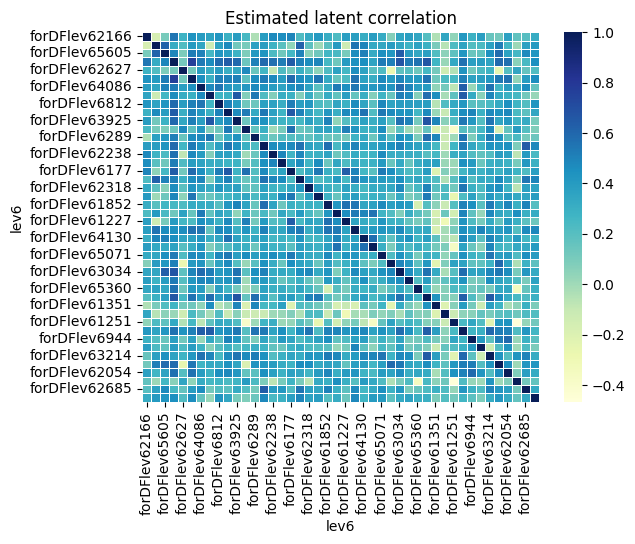

In [33]:
tps = ["tru"] * kp_obs.shape[0]
kp_latent = latentcor(kp_obs.T, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [34]:
kp_fill_idx = list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[kp_adata.var["protein"]]["lev6"].values))
kp_fill = pd.DataFrame(index=kp_fill_idx, columns=kp_fill_idx)
kp_fill.shape

(14, 14)

<Axes: >

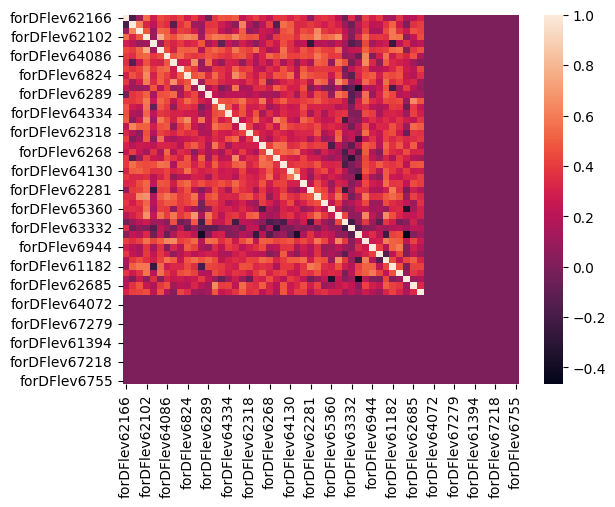

In [35]:
kp_latent_final = pd.concat([kp_latent["R"], kp_fill], axis=0)
kp_latent_final.fillna(0, inplace=True)
sns.heatmap(kp_latent_final)

In [36]:
kp_fill = pd.DataFrame(0, index=list(all_rrna_genes - set(data_nSBM["SC_proteins"].varm["protein_hierarchy"].loc[kp_adata.var["protein"]]["lev6"].values)),
             columns=kp_obs_sample.columns)
kp_fill.shape

(14, 150)

In [37]:
kp_obs_sample_final = pd.concat([kp_obs_sample, kp_fill])
kp_obs_sample_final.shape

(58, 150)

Collecting all of the obs and latent correlation into dicts

In [38]:
#all obs
all_obs = {0: ec_obs_sample_final,
           1: efm_obs_sample_final,
           2: psa_obs_sample_final,
           3: kp_obs_sample_final}
#S
S = {0: ec_latent_final,
     1: efm_latent_final,
     2: psa_latent_final,
     3: kp_latent_final}

In [41]:
assert all_obs[0].shape == all_obs[1].shape == all_obs[2].shape == all_obs[3].shape
assert S[0].shape == S[1].shape == S[2].shape == S[3].shape

### GGLASSO

In [42]:
from gglasso.helper.ext_admm_helper import create_group_array, construct_indexer, check_G

In [43]:
ix_exist, ix_location = construct_indexer(list(all_obs.values()))

In [57]:
G = create_group_array(ix_exist, ix_location, min_inst=4)

Creation of bookeeping array...
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished


In [58]:
check_G(G, 58)

In [59]:
assert np.all(G[0,:,:] <= G[1,:,:])

AssertionError: 

In [60]:
from gglasso.problem import glasso_problem

In [63]:
P = glasso_problem(S=S, N=150, reg="GGL", reg_params=None, latent=True, G=G, do_scaling=True)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'lambda2': None, 'mu1': None}


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\problem.py:254: UserWarning: NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!
  warnings.warn("NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\problem.py:255: UserWarning: The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.
  warnings.warn("The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.")


In [64]:
l1 =    np.logspace(0,-2,7)
mu1 =   np.logspace(1,-1,3)
l2 =    np.logspace(0,-2,4)

modelselect_params = {'lambda1_range' : l1, 'mu1_range': mu1, 'lambda2_range': l2}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1, tol = 1e-7, rtol = 1e-7)

print(P.reg_params)

------------Range search for instance 0------------
ADMM terminated after 1000 iterations with status: max iterations reached.


LinAlgError: Eigenvalues did not converge

In [116]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from gglasso.helper.ext_admm_helper import create_group_array, construct_indexer
from gglasso.helper.utils import sparsity
from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.helper.ext_admm_helper import check_G, consensus

from gglasso.problem import glasso_problem

K = 4
p = 50
M = 10
B = int(p/M)
N = 200

In [117]:
p_arr = (p-B)*np.ones(K, dtype = int)
num_samples = N*np.ones(K)

Sigma, Theta = generate_precision_matrix(p=p, M=M, style = 'powerlaw', gamma = 2.8, prob = 0.1, seed = 3456)

all_obs = dict()
S = dict()
for k in np.arange(K):

    _, obs = sample_covariance_matrix(Sigma, N, seed = 456)

    # drop the k-th block starting from the end
    all_obs[k] = pd.DataFrame(obs).drop(np.arange(p-(k+1)*B, p-k*B), axis = 0)
    S[k] = np.cov(all_obs[k], bias = True)

In [118]:
ix_exist, ix_location = construct_indexer(list(all_obs.values()))

G = create_group_array(ix_exist, ix_location, min_inst = K-1)

check_G(G, p)

print("Dimensions p_k: ", p_arr)

print("Sample sizes N_k: ", num_samples)

print("Number of groups found: ", G.shape[1])

Creation of bookeeping array...
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished
Dimensions p_k:  [45 45 45 45]
Sample sizes N_k:  [200. 200. 200. 200.]
Number of groups found:  1075


In [113]:
np.all(G[0,:,:] <= G[1,:,:])

False

<Axes: >

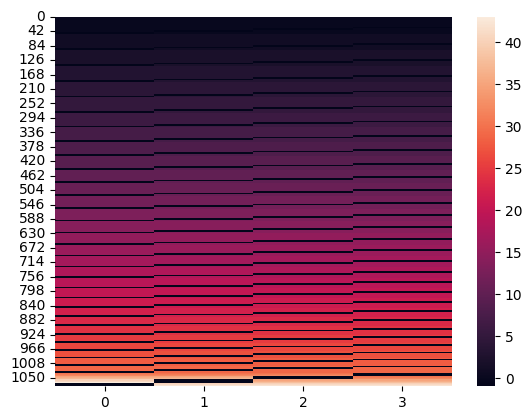

In [119]:
sns.heatmap(G[0])

<Axes: >

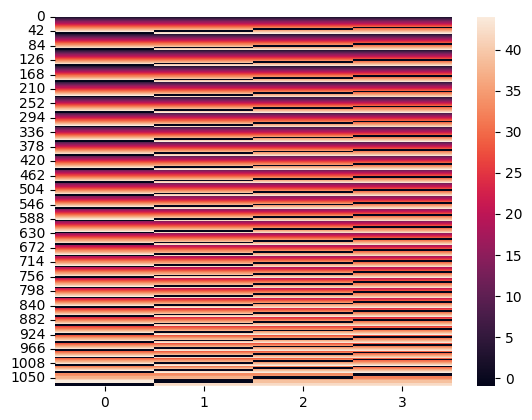

In [120]:
sns.heatmap(G[1])

In [131]:
list(all_obs.values())

[         0         1         2         3         4         5         6    \
 0   1.002432 -0.715867 -1.454853  1.170536  0.587830 -0.963646  0.906611   
 1  -0.757370 -0.188349 -0.365002 -1.939941  1.154111  1.380403 -0.884834   
 2  -0.550031 -0.104259 -1.441823  0.674876 -0.718124  0.276665 -1.376068   
 3  -1.227965  0.051565 -0.661891 -0.017938  2.890384 -0.867189  1.023273   
 4  -0.553694  0.434673 -0.903712 -0.507081 -0.562264  1.292903 -0.374739   
 5   0.080165  0.837853 -0.056718 -1.232267 -0.368469 -0.129041  0.936211   
 6   1.163824  0.364617 -1.897096 -0.200039 -0.968897 -0.349542 -1.049968   
 7  -0.091393 -2.424766 -0.635897 -0.270862 -0.089841 -0.660835  0.758776   
 8  -0.352766 -0.151081  1.522903 -0.425630  1.308369  0.776795 -2.200174   
 9   0.629975 -0.209143 -2.309681 -0.336698 -1.654203 -0.775426  0.862800   
 10 -1.946927 -1.876740  0.109876 -0.178533  1.066500 -0.775333 -0.691093   
 11  1.052693 -1.217362  0.937633 -0.603293  2.717467  0.419471 -2.052930   